------
# <b>TP5 - ALTEGRAD 2023 - Deep Learning for Graphs (1/2)</b>
## MARENGO Matteo | matteo.marengo@ens-paris-saclay.fr
## <b>PART 1 - Node Embeddings</b>
------

# <b>1 - Implementation of DeepWalk</b>
## <b>TASK 1 / 2</b>

In [1]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
MARENGO Matteo
matteo.marengo@ens-paris-saclay.fr
SCRIPT 1/3 - DEEPWALK
"""

import numpy as np
import networkx as nx
from random import randint
from gensim.models import Word2Vec

############## Task 1
# Simulates a random walk of length "walk_length" starting from node "node"
def random_walk(G, node, walk_length):

    ##################
    walk = [node] # walk starts from node
    for i in range(walk_length-1): # walk has length walk_length
        neighbour = list(G.neighbors(walk[i])) # list of neighbors of current node
        walk.append(neighbour[randint(0,len(neighbour)-1)]) # next node is randomly chosen among neighbors of current node
        
    ##################
    # We transform the nodes from integers to strings
    # Indeed, the Word2Vec model only accepts strings as input
    walk = [str(node) for node in walk]
    return walk

############## Task 2
# Runs "num_walks" random walks from each node
def generate_walks(G, num_walks, walk_length):
    walks = []
    
    ##################
    # Runs "num_walks" random walks from each node
    for node in G.nodes():
        for i in range(num_walks):
            walks.append(random_walk(G, node, walk_length))
    # permute walks
    # a permutation is a random shuffling of the walks
    # It is done to avoid that the walks are ordered by node
    permuted_walks = np.random.permutation(walks)
    ##################

    return permuted_walks.tolist()

# Simulates walks and uses the Skipgram model to learn node representations
def deepwalk(G, num_walks, walk_length, n_dim):
    print("Generating walks")
    walks = generate_walks(G, num_walks, walk_length)

    print("Training word2vec")
    model = Word2Vec(vector_size=n_dim, window=8, min_count=0, sg=1, workers=8, hs=1)
    model.build_vocab(walks)
    model.train(walks, total_examples=model.corpus_count, epochs=5)

    return model


# <b>2 - Visualization of the French Web</b>
## <b>TASK 3 / 4</b>

Number of nodes: 33226
Number of edges: 354529
Generating walks
Training word2vec


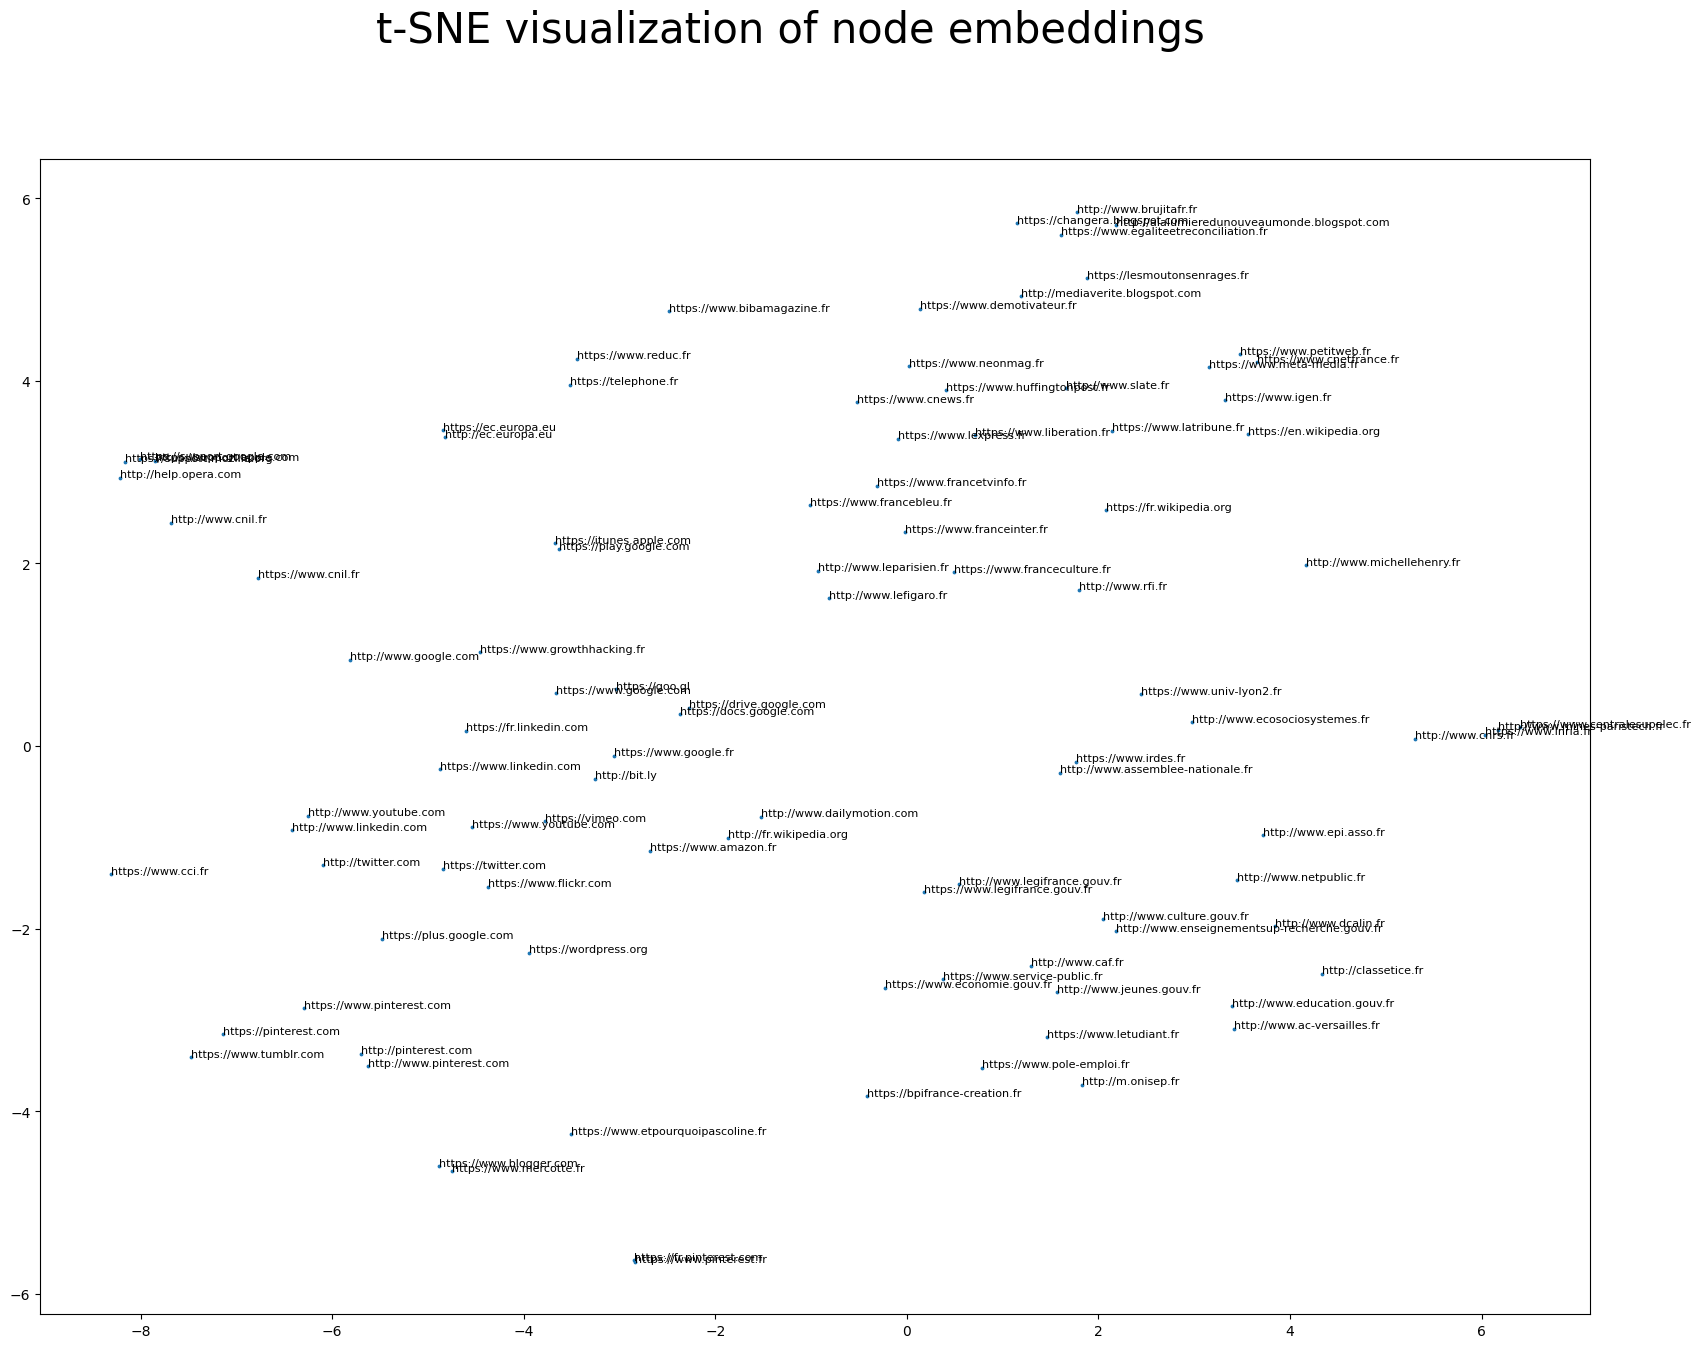

In [2]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
MARENGO Matteo
matteo.marengo@ens-paris-saclay.fr
SCRIPT 2/3 - VISUALIZATION
"""

import networkx as nx
import numpy as np
# from deepwalk import deepwalk
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Loads the web graph
G = nx.read_weighted_edgelist('../data/web_sample.edgelist', delimiter=' ', create_using=nx.Graph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

############## Task 3
# Extracts a set of random walks from the web graph and feeds them to the Skipgram model
n_dim = 128
n_walks = 10
walk_length = 20

##################
model = deepwalk(G, n_walks, walk_length, n_dim)
##################

############## Task 4
# Visualizes the representations of the 100 nodes that appear most frequently in the generated walks
def visualize(model, n, dim):
    nodes = model.wv.index_to_key[:n] # your code here
    DeepWalk_embeddings = np.empty(shape=(n, dim))
    
    ##################
    # Store the representations of these 100 nodes in a 100 x 128 matrix
    for idx,node in enumerate(nodes):
        DeepWalk_embeddings[idx, :] = model.wv[node]
    ##################

    my_pca = PCA(n_components=10)
    my_tsne = TSNE(n_components=2)

    vecs_pca = my_pca.fit_transform(DeepWalk_embeddings)
    vecs_tsne = my_tsne.fit_transform(vecs_pca)

    fig, ax = plt.subplots()
    ax.scatter(vecs_tsne[:,0], vecs_tsne[:,1],s=3)
    for x, y, node in zip(vecs_tsne[:,0] , vecs_tsne[:,1], nodes):     
        ax.annotate(node, xy=(x, y), size=8)
    fig.suptitle('t-SNE visualization of node embeddings',fontsize=30)
    fig.set_size_inches(20,15)
    plt.savefig('embeddings.pdf')  
    plt.show()


visualize(model, 100, n_dim)

# <b>3 - Node Classification</b>
## <b>TASK 5 / 6 / 7 / 8 </b>

Number of nodes: 34
Number of edges: 78
Generating walks
Training word2vec
Accuracy with DeepWalk: 1.0
Accuracy Spectral Embeddings: 0.8571428571428571


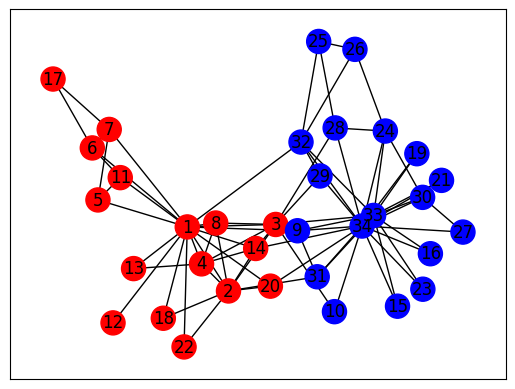

In [4]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
MARENGO Matteo 
matteo.marengo@ens-paris-saclay.fr
SCRIPT 3/3 - NODE CLASSIFICATION 
"""

import networkx as nx
import numpy as np
from scipy.sparse.linalg import eigs
from scipy.sparse import diags, eye

from sklearn.linear_model import LogisticRegression
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import accuracy_score
# from deepwalk import deepwalk

# Loads the karate network
G = nx.read_weighted_edgelist('../data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('../data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)


############## Task 5
# Visualizes the karate network

##################
# your code here #
# Assign some color to the nodes belong to the first class and another color to nodes that belong to the second class
color_map = []
for node in G:
    if idx_to_class_label[node] == 1:
        color_map.append('blue')
    else:
        color_map.append('red')
nx.draw_networkx(G, node_color=color_map)
##################


############## Task 6
# Extracts a set of random walks from the karate network and feeds them to the Skipgram model
n_dim = 128
n_walks = 10
walk_length = 20
# your code here
model = deepwalk(G, n_walks, walk_length, n_dim)

embeddings = np.zeros((n, n_dim))
for i, node in enumerate(G.nodes()):
    embeddings[i,:] = model.wv[str(node)]

idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

X_train = embeddings[idx_train,:]
X_test = embeddings[idx_test,:]

y_train = y[idx_train]
y_test = y[idx_test]


############## Task 7
# Trains a logistic regression classifier on the training dataand use it to make predictions on the test set
##################
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy with DeepWalk:", acc)
##################


############## Task 8
# Generates spectral embeddings

##################
# your code here #

# VERSION FROM LAB #2

def spectral_clustering(G, k):

    ##################
    #1 Compute adjacency matrix
    A = nx.adjacency_matrix(G).astype(float)

    #2.1 Compute degree matrix D (as a diagonal matrix)
    degrees = np.array(A.sum(axis=1)).flatten()
    D = diags(degrees)

    #2.2 Compute the normalized Laplacian matrix: Lrw = I - D^(-1)A
    D_inv = diags(1.0 / degrees)
    Lrw = eye(G.number_of_nodes()) - D_inv @ A

    # Compute the k smallest eigenvectors
    evalval, evecval = eigs(Lrw, k=k, which='SR') 

    evecval = np.real(evecval)
    evecval = evecval[:, np.argsort(evalval)]
    ###############
    return evecval

k = 2
evecval = spectral_clustering(G, k)

X_train = evecval[idx_train,:]
X_test = evecval[idx_test,:]

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy Spectral Embeddings:", acc)
##################
